In [1]:
## import the necessary libraries for time series modelling
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.statespace.tools import diff

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Singapore Electricity Generation.csv')
df = df.drop(columns=['Data Series'])
df = df.T
df.index.name = 'Date'
df.columns = ['Electricity Generation']
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)
df

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2022-01-01,4780.2
2022-02-01,4287.3
2022-03-01,4886.1


### Data Exploration

<AxesSubplot:xlabel='Date'>

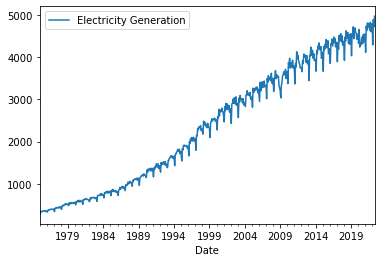

In [3]:
df.plot()

In [4]:
## checking for any null values
print(df.isnull().sum())

Electricity Generation    0
dtype: int64


<AxesSubplot:ylabel='Frequency'>

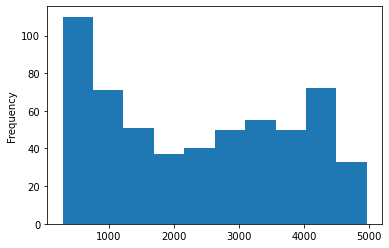

In [5]:
df['Electricity Generation'].plot(kind='hist')

<AxesSubplot:xlabel='Electricity Generation'>

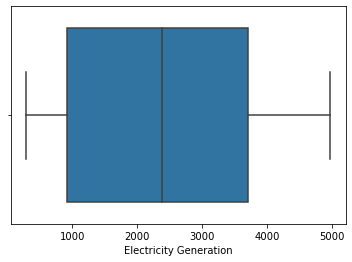

In [6]:
sns.boxplot(df['Electricity Generation'])

### Decomposition Plot

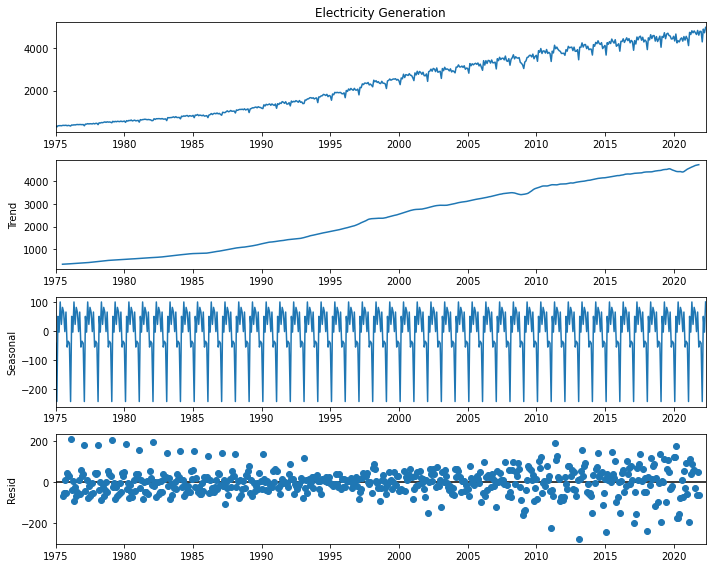

In [7]:
result = seasonal_decompose(df['Electricity Generation'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

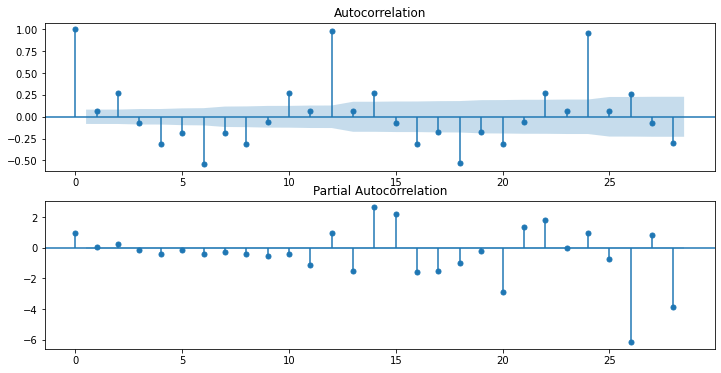

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [9]:
df

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2022-01-01,4780.2
2022-02-01,4287.3
2022-03-01,4886.1


### Stationarity

In [10]:
## checking for stationarity
test1 = df[df.index<='1998-08']
test2 = df[df.index>'1998-08']
test1Mean = test1['Electricity Generation'].mean()
test2Mean = test2['Electricity Generation'].mean()
test1Var = test1['Electricity Generation'].var()
test2Var = test2['Electricity Generation'].var()
print(f'Group 1 Mean: {test1Mean} | Group 2 Mean: {test2Mean}')
print(f'Group 1 Var: {test1Var} | Group 2 Var: {test2Var}')

Group 1 Mean: 1080.444366197183 | Group 2 Mean: 3655.986315789474
Group 1 Var: 337523.61427910224 | Group 2 Var: 477835.21470644913


In [11]:
## conduct augmented dicky fuller test
pval = adfuller(df['Electricity Generation'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.990521


In [12]:
df = df.diff()
df = df.dropna()
df

,Electricity Generation
Date,
1975-02-01,-52.2
1975-03-01,53.2
1975-04-01,5.8
1975-05-01,2.8
1975-06-01,-8.1
...,...
2022-01-01,-3.7
2022-02-01,-492.9
2022-03-01,598.8


In [13]:
## conduct augmented dicky fuller test
pval = adfuller(df['Electricity Generation'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.000000


### ACF and PACF Plots

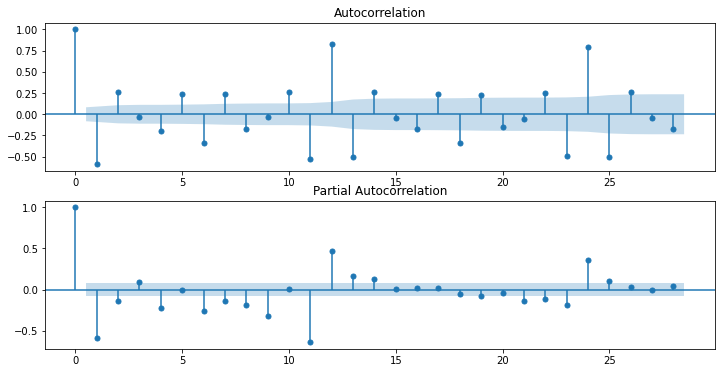

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['Electricity Generation'], ax=ax[0])
plot_pacf(df['Electricity Generation'], ax=ax[1])
plt.show()

### Simple Moving Average Model

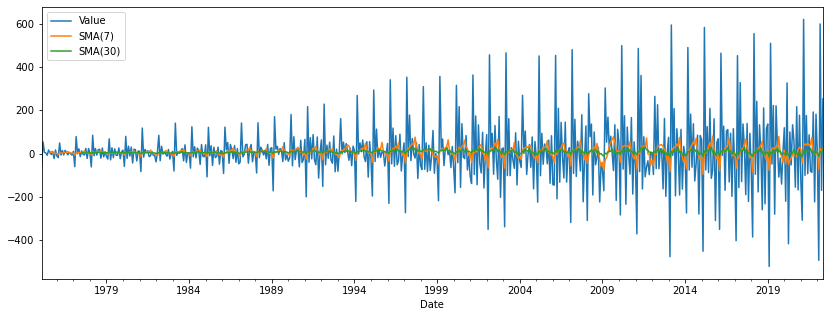

In [15]:
## Simple Moving Average Model
df_SMA = df['Electricity Generation']
ax = df_SMA.plot(figsize=(14, 5))
df_SMA.rolling(window=7).mean().plot(ax=ax)
df_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)'])
plt.show()

In [16]:
# exogCO = CO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(df['Electricity Generation'], order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Electricity Generation   No. Observations:                  568
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3052.180
Date:                            Mon, 08 Aug 2022   AIC                           6114.360
Time:                                    01:57:52   BIC                           6135.955
Sample:                                02-01-1975   HQIC                          6122.796
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3720      0.029    -12.852      0.000      -0.429      -0.315
ma.L1         -0.9998      0.146     -6.849      0.000      -1.286      -0.714
ar.S.L12      -0.1329      0.046     -2.862      0.004      -0.224      -0.042
ma.S.L12      -0.7169      0.032    -22.372      0.000      -0.780      -0.654
sigma2      3374.6961    468.037      7.210      0.000    2457.360    4292.032
===================================================================================
Ljung-Box (L1) (Q):                   3.17   Jarque-Bera (JB):               698.25
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              13.27   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(df['Electricity Generation'], pred)
mape = mean_absolute_percentage_error(df['Electricity Generation'], pred)
mse = mean_squared_error(df['Electricity Generation'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,39.972869,1.764151e+14,3350.181791,57.880755


In [3]:
## split into train and test data
train_data = df[df.index<='1998-09']
test_data = df[df.index>'1998-09']

In [19]:
## define params
orders = [(1,0,1),(1,0,2),(1,0,3),(1,0,4),(1,0,5),(1,0,6),(1,0,7),
          (1,1,1),(1,1,2),(1,1,3),(1,1,4),(1,1,5),(1,1,6),(1,1,7),
          (2,0,1),(2,0,2),(2,0,3),(2,0,4),(2,0,5),(2,0,6),(2,0,7),
          (2,1,1),(2,1,2),(2,1,3),(2,1,4),(2,1,5),(2,1,6),(2,1,7),
          (3,0,1),(3,0,2),(3,0,3),(3,0,4),(3,0,5),(3,0,6),(3,0,6),
          (3,1,1),(3,1,2),(3,1,3),(3,1,4),(3,1,5),(3,1,6),(3,1,7),
          (4,0,1),(4,0,2),(4,0,3),(4,0,4),(4,0,5),(4,0,6),(4,0,7),
          (4,1,1),(4,1,2),(4,1,3),(4,1,4),(4,1,5),(4,1,6),(4,1,7),
          (5,0,1),(5,0,2),(5,0,3),(5,0,4),(5,0,5),(5,0,6),(5,0,7),
          (5,1,1),(5,1,2),(5,1,3),(5,1,4),(5,1,5),(5,1,6),(5,1,7)]
#           (6,0,1),(6,0,2),(6,0,3),(6,0,4),(6,0,5),(6,0,6),(6,0,7),
#           (6,1,1),(6,1,2),(6,1,3),(6,1,4),(6,1,5),(6,1,6),(6,1,7),
#           (7,0,1),(7,0,2),(7,0,3),(7,0,4),(7,0,5),(7,0,6),(7,0,7),
#           (7,1,1),(7,1,2),(7,1,3),(7,1,4),(7,1,5),(7,1,6),(7,1,7)
          

seasonal_orders = [(1,0,1,12),(1,0,2,12),(1,0,3,12),(1,0,4,12),(1,0,5,12),(1,0,6,12),(1,0,7,12),
          (1,1,1,12),(1,1,2,12),(1,1,3,12),(1,1,4,12),(1,1,5,12),(1,1,6,12),(1,1,7,12),
          (2,0,1,12),(2,0,2,12),(2,0,3,12),(2,0,4,12),(2,0,5,12),(2,0,6,12),(2,0,7,12),
          (2,1,1,12),(2,1,2,12),(2,1,3,12),(2,1,4,12),(2,1,5,12),(2,1,6,12),(2,1,7,1),
          (3,0,1,12),(3,0,2,12),(3,0,3,12),(3,0,4,12),(3,0,5,12),(3,0,6,12),(3,0,6,12),
          (3,1,1,12),(3,1,2,12),(3,1,3,12),(3,1,4,12),(3,1,5,12),(3,1,6,12),(3,1,7,12),
          (4,0,1,12),(4,0,2,12),(4,0,3,12),(4,0,4,12),(4,0,5,12),(4,0,6,12),(4,0,7,12),
          (4,1,1,12),(4,1,2,12),(4,1,3,12),(4,1,4,12),(4,1,5,12),(4,1,6,12),(4,1,7,12),
          (5,0,1,12),(5,0,2,12),(5,0,3,12),(5,0,4,12),(5,0,5,12),(5,0,6,12),(5,0,7,12),
          (5,1,1,12),(5,1,2,12),(5,1,3,12),(5,1,4,12),(5,1,5,12),(5,1,6,12),(5,1,7,12)]
#           (6,0,1,12),(6,0,2,12),(6,0,3,12),(6,0,4,12),(6,0,5,12),(6,0,6,12),(6,0,7,12),
#           (6,1,1,12),(6,1,2,12),(6,1,3,12),(6,1,4,12),(6,1,5,12),(6,1,6,12),(6,1,7,12),
#           (7,0,1,12),(7,0,2,12),(7,0,3,12),(7,0,4,12),(7,0,5,12),(7,0,6,12),(7,0,7,12),
#           (7,1,1,12),(7,1,2,12),(7,1,3,12),(7,1,4,12),(7,1,5,12),(7,1,6,12),(7,1,7,12)
          

In [20]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order),str(seasonal_order))
        try:
            arima_model = SARIMAX(train_data['Electricity Generation'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n').fit()
        
            pred = arima_model.get_prediction(start='1975-02', end='2022-05').predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Electricity Generation'], pred[pred.index<='1998-09'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Electricity Generation'], pred[pred.index>'1998-09'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("")

trying (1, 0, 1) (1, 0, 1, 12)
trying (1, 0, 1) (1, 0, 2, 12)
trying (1, 0, 1) (1, 0, 3, 12)
trying (1, 0, 1) (1, 0, 4, 12)
trying (1, 0, 1) (1, 0, 5, 12)
trying (1, 0, 1) (1, 0, 6, 12)
trying (1, 0, 1) (1, 0, 7, 12)
trying (1, 0, 1) (1, 1, 1, 12)
trying (1, 0, 1) (1, 1, 2, 12)
trying (1, 0, 1) (1, 1, 3, 12)
trying (1, 0, 1) (1, 1, 4, 12)
trying (1, 0, 1) (1, 1, 5, 12)
trying (1, 0, 1) (1, 1, 6, 12)
trying (1, 0, 1) (1, 1, 7, 12)
trying (1, 0, 1) (2, 0, 1, 12)
trying (1, 0, 1) (2, 0, 2, 12)
trying (1, 0, 1) (2, 0, 3, 12)
trying (1, 0, 1) (2, 0, 4, 12)
trying (1, 0, 1) (2, 0, 5, 12)

trying (1, 0, 1) (2, 0, 6, 12)
trying (1, 0, 1) (2, 0, 7, 12)
trying (1, 0, 1) (2, 1, 1, 12)
trying (1, 0, 1) (2, 1, 2, 12)
trying (1, 0, 1) (2, 1, 3, 12)
trying (1, 0, 1) (2, 1, 4, 12)
trying (1, 0, 1) (2, 1, 5, 12)
trying (1, 0, 1) (2, 1, 6, 12)
trying (1, 0, 1) (2, 1, 7, 1)

trying (1, 0, 1) (3, 0, 1, 12)
trying (1, 0, 1) (3, 0, 2, 12)
trying (1, 0, 1) (3, 0, 3, 12)

trying (1, 0, 1) (3, 0, 4, 12)
trying

trying (1, 0, 4) (4, 1, 6, 12)
trying (1, 0, 4) (4, 1, 7, 12)
trying (1, 0, 4) (5, 0, 1, 12)
trying (1, 0, 4) (5, 0, 2, 12)
trying (1, 0, 4) (5, 0, 3, 12)
trying (1, 0, 4) (5, 0, 4, 12)
trying (1, 0, 4) (5, 0, 5, 12)
trying (1, 0, 4) (5, 0, 6, 12)
trying (1, 0, 4) (5, 0, 7, 12)
trying (1, 0, 4) (5, 1, 1, 12)
trying (1, 0, 4) (5, 1, 2, 12)
trying (1, 0, 4) (5, 1, 3, 12)
trying (1, 0, 4) (5, 1, 4, 12)
trying (1, 0, 4) (5, 1, 5, 12)
trying (1, 0, 4) (5, 1, 6, 12)
trying (1, 0, 4) (5, 1, 7, 12)
trying (1, 0, 5) (1, 0, 1, 12)
trying (1, 0, 5) (1, 0, 2, 12)
trying (1, 0, 5) (1, 0, 3, 12)
trying (1, 0, 5) (1, 0, 4, 12)
trying (1, 0, 5) (1, 0, 5, 12)
trying (1, 0, 5) (1, 0, 6, 12)
trying (1, 0, 5) (1, 0, 7, 12)
trying (1, 0, 5) (1, 1, 1, 12)
trying (1, 0, 5) (1, 1, 2, 12)
trying (1, 0, 5) (1, 1, 3, 12)
trying (1, 0, 5) (1, 1, 4, 12)
trying (1, 0, 5) (1, 1, 5, 12)
trying (1, 0, 5) (1, 1, 6, 12)
trying (1, 0, 5) (1, 1, 7, 12)
trying (1, 0, 5) (2, 0, 1, 12)
trying (1, 0, 5) (2, 0, 2, 12)
trying (

trying (1, 1, 1) (3, 1, 4, 12)
trying (1, 1, 1) (3, 1, 5, 12)
trying (1, 1, 1) (3, 1, 6, 12)
trying (1, 1, 1) (3, 1, 7, 12)
trying (1, 1, 1) (4, 0, 1, 12)
trying (1, 1, 1) (4, 0, 2, 12)
trying (1, 1, 1) (4, 0, 3, 12)

trying (1, 1, 1) (4, 0, 4, 12)
trying (1, 1, 1) (4, 0, 5, 12)

trying (1, 1, 1) (4, 0, 6, 12)
trying (1, 1, 1) (4, 0, 7, 12)
trying (1, 1, 1) (4, 1, 1, 12)
trying (1, 1, 1) (4, 1, 2, 12)
trying (1, 1, 1) (4, 1, 3, 12)
trying (1, 1, 1) (4, 1, 4, 12)
trying (1, 1, 1) (4, 1, 5, 12)
trying (1, 1, 1) (4, 1, 6, 12)
trying (1, 1, 1) (4, 1, 7, 12)
trying (1, 1, 1) (5, 0, 1, 12)
trying (1, 1, 1) (5, 0, 2, 12)
trying (1, 1, 1) (5, 0, 3, 12)

trying (1, 1, 1) (5, 0, 4, 12)

trying (1, 1, 1) (5, 0, 5, 12)
trying (1, 1, 1) (5, 0, 6, 12)

trying (1, 1, 1) (5, 0, 7, 12)
trying (1, 1, 1) (5, 1, 1, 12)
trying (1, 1, 1) (5, 1, 2, 12)
trying (1, 1, 1) (5, 1, 3, 12)
trying (1, 1, 1) (5, 1, 4, 12)
trying (1, 1, 1) (5, 1, 5, 12)
trying (1, 1, 1) (5, 1, 6, 12)
trying (1, 1, 1) (5, 1, 7, 12)
try

trying (1, 1, 5) (2, 1, 2, 12)
trying (1, 1, 5) (2, 1, 3, 12)
trying (1, 1, 5) (2, 1, 4, 12)
trying (1, 1, 5) (2, 1, 5, 12)
trying (1, 1, 5) (2, 1, 6, 12)
trying (1, 1, 5) (2, 1, 7, 1)

trying (1, 1, 5) (3, 0, 1, 12)
trying (1, 1, 5) (3, 0, 2, 12)
trying (1, 1, 5) (3, 0, 3, 12)
trying (1, 1, 5) (3, 0, 4, 12)
trying (1, 1, 5) (3, 0, 5, 12)

trying (1, 1, 5) (3, 0, 6, 12)

trying (1, 1, 5) (3, 0, 6, 12)

trying (1, 1, 5) (3, 1, 1, 12)
trying (1, 1, 5) (3, 1, 2, 12)
trying (1, 1, 5) (3, 1, 3, 12)
trying (1, 1, 5) (3, 1, 4, 12)
trying (1, 1, 5) (3, 1, 5, 12)
trying (1, 1, 5) (3, 1, 6, 12)
trying (1, 1, 5) (3, 1, 7, 12)
trying (1, 1, 5) (4, 0, 1, 12)
trying (1, 1, 5) (4, 0, 2, 12)
trying (1, 1, 5) (4, 0, 3, 12)

trying (1, 1, 5) (4, 0, 4, 12)
trying (1, 1, 5) (4, 0, 5, 12)
trying (1, 1, 5) (4, 0, 6, 12)

trying (1, 1, 5) (4, 0, 7, 12)
trying (1, 1, 5) (4, 1, 1, 12)
trying (1, 1, 5) (4, 1, 2, 12)
trying (1, 1, 5) (4, 1, 3, 12)
trying (1, 1, 5) (4, 1, 4, 12)
trying (1, 1, 5) (4, 1, 5, 12)
try


trying (2, 0, 2) (1, 0, 7, 12)
trying (2, 0, 2) (1, 1, 1, 12)
trying (2, 0, 2) (1, 1, 2, 12)
trying (2, 0, 2) (1, 1, 3, 12)
trying (2, 0, 2) (1, 1, 4, 12)
trying (2, 0, 2) (1, 1, 5, 12)
trying (2, 0, 2) (1, 1, 6, 12)
trying (2, 0, 2) (1, 1, 7, 12)
trying (2, 0, 2) (2, 0, 1, 12)
trying (2, 0, 2) (2, 0, 2, 12)
trying (2, 0, 2) (2, 0, 3, 12)
trying (2, 0, 2) (2, 0, 4, 12)
trying (2, 0, 2) (2, 0, 5, 12)
trying (2, 0, 2) (2, 0, 6, 12)
trying (2, 0, 2) (2, 0, 7, 12)

trying (2, 0, 2) (2, 1, 1, 12)
trying (2, 0, 2) (2, 1, 2, 12)
trying (2, 0, 2) (2, 1, 3, 12)
trying (2, 0, 2) (2, 1, 4, 12)
trying (2, 0, 2) (2, 1, 5, 12)
trying (2, 0, 2) (2, 1, 6, 12)
trying (2, 0, 2) (2, 1, 7, 1)

trying (2, 0, 2) (3, 0, 1, 12)
trying (2, 0, 2) (3, 0, 2, 12)
trying (2, 0, 2) (3, 0, 3, 12)

trying (2, 0, 2) (3, 0, 4, 12)

trying (2, 0, 2) (3, 0, 5, 12)
trying (2, 0, 2) (3, 0, 6, 12)
trying (2, 0, 2) (3, 0, 6, 12)
trying (2, 0, 2) (3, 1, 1, 12)
trying (2, 0, 2) (3, 1, 2, 12)
trying (2, 0, 2) (3, 1, 3, 12)
tryi

trying (2, 0, 5) (5, 0, 5, 12)
trying (2, 0, 5) (5, 0, 6, 12)
trying (2, 0, 5) (5, 0, 7, 12)
trying (2, 0, 5) (5, 1, 1, 12)
trying (2, 0, 5) (5, 1, 2, 12)
trying (2, 0, 5) (5, 1, 3, 12)
trying (2, 0, 5) (5, 1, 4, 12)
trying (2, 0, 5) (5, 1, 5, 12)
trying (2, 0, 5) (5, 1, 6, 12)
trying (2, 0, 5) (5, 1, 7, 12)
trying (2, 0, 6) (1, 0, 1, 12)
trying (2, 0, 6) (1, 0, 2, 12)
trying (2, 0, 6) (1, 0, 3, 12)
trying (2, 0, 6) (1, 0, 4, 12)
trying (2, 0, 6) (1, 0, 5, 12)
trying (2, 0, 6) (1, 0, 6, 12)
trying (2, 0, 6) (1, 0, 7, 12)
trying (2, 0, 6) (1, 1, 1, 12)
trying (2, 0, 6) (1, 1, 2, 12)
trying (2, 0, 6) (1, 1, 3, 12)
trying (2, 0, 6) (1, 1, 4, 12)
trying (2, 0, 6) (1, 1, 5, 12)
trying (2, 0, 6) (1, 1, 6, 12)
trying (2, 0, 6) (1, 1, 7, 12)
trying (2, 0, 6) (2, 0, 1, 12)
trying (2, 0, 6) (2, 0, 2, 12)
trying (2, 0, 6) (2, 0, 3, 12)
trying (2, 0, 6) (2, 0, 4, 12)
trying (2, 0, 6) (2, 0, 5, 12)

trying (2, 0, 6) (2, 0, 6, 12)
trying (2, 0, 6) (2, 0, 7, 12)
trying (2, 0, 6) (2, 1, 1, 12)
trying 

trying (2, 1, 2) (4, 0, 3, 12)

trying (2, 1, 2) (4, 0, 4, 12)

trying (2, 1, 2) (4, 0, 5, 12)

trying (2, 1, 2) (4, 0, 6, 12)

trying (2, 1, 2) (4, 0, 7, 12)
trying (2, 1, 2) (4, 1, 1, 12)
trying (2, 1, 2) (4, 1, 2, 12)
trying (2, 1, 2) (4, 1, 3, 12)
trying (2, 1, 2) (4, 1, 4, 12)
trying (2, 1, 2) (4, 1, 5, 12)
trying (2, 1, 2) (4, 1, 6, 12)
trying (2, 1, 2) (4, 1, 7, 12)
trying (2, 1, 2) (5, 0, 1, 12)
trying (2, 1, 2) (5, 0, 2, 12)
trying (2, 1, 2) (5, 0, 3, 12)

trying (2, 1, 2) (5, 0, 4, 12)

trying (2, 1, 2) (5, 0, 5, 12)

trying (2, 1, 2) (5, 0, 6, 12)

trying (2, 1, 2) (5, 0, 7, 12)

trying (2, 1, 2) (5, 1, 1, 12)
trying (2, 1, 2) (5, 1, 2, 12)
trying (2, 1, 2) (5, 1, 3, 12)
trying (2, 1, 2) (5, 1, 4, 12)
trying (2, 1, 2) (5, 1, 5, 12)
trying (2, 1, 2) (5, 1, 6, 12)
trying (2, 1, 2) (5, 1, 7, 12)

trying (2, 1, 3) (1, 0, 1, 12)

trying (2, 1, 3) (1, 0, 2, 12)
trying (2, 1, 3) (1, 0, 3, 12)
trying (2, 1, 3) (1, 0, 4, 12)

trying (2, 1, 3) (1, 0, 5, 12)
trying (2, 1, 3) (1, 0, 6, 

trying (2, 1, 6) (2, 1, 7, 1)

trying (2, 1, 6) (3, 0, 1, 12)
trying (2, 1, 6) (3, 0, 2, 12)
trying (2, 1, 6) (3, 0, 3, 12)
trying (2, 1, 6) (3, 0, 4, 12)
trying (2, 1, 6) (3, 0, 5, 12)
trying (2, 1, 6) (3, 0, 6, 12)
trying (2, 1, 6) (3, 0, 6, 12)
trying (2, 1, 6) (3, 1, 1, 12)
trying (2, 1, 6) (3, 1, 2, 12)
trying (2, 1, 6) (3, 1, 3, 12)
trying (2, 1, 6) (3, 1, 4, 12)
trying (2, 1, 6) (3, 1, 5, 12)
trying (2, 1, 6) (3, 1, 6, 12)
trying (2, 1, 6) (3, 1, 7, 12)
trying (2, 1, 6) (4, 0, 1, 12)
trying (2, 1, 6) (4, 0, 2, 12)
trying (2, 1, 6) (4, 0, 3, 12)
trying (2, 1, 6) (4, 0, 4, 12)
trying (2, 1, 6) (4, 0, 5, 12)
trying (2, 1, 6) (4, 0, 6, 12)
trying (2, 1, 6) (4, 0, 7, 12)
trying (2, 1, 6) (4, 1, 1, 12)
trying (2, 1, 6) (4, 1, 2, 12)
trying (2, 1, 6) (4, 1, 3, 12)
trying (2, 1, 6) (4, 1, 4, 12)
trying (2, 1, 6) (4, 1, 5, 12)
trying (2, 1, 6) (4, 1, 6, 12)
trying (2, 1, 6) (4, 1, 7, 12)
trying (2, 1, 6) (5, 0, 1, 12)
trying (2, 1, 6) (5, 0, 2, 12)
trying (2, 1, 6) (5, 0, 3, 12)
trying (

trying (3, 0, 3) (1, 1, 5, 12)
trying (3, 0, 3) (1, 1, 6, 12)
trying (3, 0, 3) (1, 1, 7, 12)
trying (3, 0, 3) (2, 0, 1, 12)

trying (3, 0, 3) (2, 0, 2, 12)
trying (3, 0, 3) (2, 0, 3, 12)
trying (3, 0, 3) (2, 0, 4, 12)
trying (3, 0, 3) (2, 0, 5, 12)

trying (3, 0, 3) (2, 0, 6, 12)
trying (3, 0, 3) (2, 0, 7, 12)
trying (3, 0, 3) (2, 1, 1, 12)
trying (3, 0, 3) (2, 1, 2, 12)
trying (3, 0, 3) (2, 1, 3, 12)
trying (3, 0, 3) (2, 1, 4, 12)
trying (3, 0, 3) (2, 1, 5, 12)
trying (3, 0, 3) (2, 1, 6, 12)
trying (3, 0, 3) (2, 1, 7, 1)

trying (3, 0, 3) (3, 0, 1, 12)

trying (3, 0, 3) (3, 0, 2, 12)
trying (3, 0, 3) (3, 0, 3, 12)
trying (3, 0, 3) (3, 0, 4, 12)
trying (3, 0, 3) (3, 0, 5, 12)
trying (3, 0, 3) (3, 0, 6, 12)
trying (3, 0, 3) (3, 0, 6, 12)
trying (3, 0, 3) (3, 1, 1, 12)
trying (3, 0, 3) (3, 1, 2, 12)
trying (3, 0, 3) (3, 1, 3, 12)
trying (3, 0, 3) (3, 1, 4, 12)

trying (3, 0, 3) (3, 1, 5, 12)
trying (3, 0, 3) (3, 1, 6, 12)
trying (3, 0, 3) (3, 1, 7, 12)
trying (3, 0, 3) (4, 0, 1, 12)

try

trying (3, 0, 6) (5, 1, 3, 12)
trying (3, 0, 6) (5, 1, 4, 12)
trying (3, 0, 6) (5, 1, 5, 12)
trying (3, 0, 6) (5, 1, 6, 12)
trying (3, 0, 6) (5, 1, 7, 12)
trying (3, 0, 6) (1, 0, 1, 12)
trying (3, 0, 6) (1, 0, 2, 12)
trying (3, 0, 6) (1, 0, 3, 12)
trying (3, 0, 6) (1, 0, 4, 12)
trying (3, 0, 6) (1, 0, 5, 12)
trying (3, 0, 6) (1, 0, 6, 12)
trying (3, 0, 6) (1, 0, 7, 12)
trying (3, 0, 6) (1, 1, 1, 12)
trying (3, 0, 6) (1, 1, 2, 12)
trying (3, 0, 6) (1, 1, 3, 12)
trying (3, 0, 6) (1, 1, 4, 12)
trying (3, 0, 6) (1, 1, 5, 12)
trying (3, 0, 6) (1, 1, 6, 12)
trying (3, 0, 6) (1, 1, 7, 12)
trying (3, 0, 6) (2, 0, 1, 12)

trying (3, 0, 6) (2, 0, 2, 12)
trying (3, 0, 6) (2, 0, 3, 12)
trying (3, 0, 6) (2, 0, 4, 12)
trying (3, 0, 6) (2, 0, 5, 12)
trying (3, 0, 6) (2, 0, 6, 12)
trying (3, 0, 6) (2, 0, 7, 12)
trying (3, 0, 6) (2, 1, 1, 12)
trying (3, 0, 6) (2, 1, 2, 12)
trying (3, 0, 6) (2, 1, 3, 12)
trying (3, 0, 6) (2, 1, 4, 12)
trying (3, 0, 6) (2, 1, 5, 12)
trying (3, 0, 6) (2, 1, 6, 12)
trying 

trying (3, 1, 3) (4, 1, 1, 12)
trying (3, 1, 3) (4, 1, 2, 12)
trying (3, 1, 3) (4, 1, 3, 12)
trying (3, 1, 3) (4, 1, 4, 12)
trying (3, 1, 3) (4, 1, 5, 12)
trying (3, 1, 3) (4, 1, 6, 12)
trying (3, 1, 3) (4, 1, 7, 12)
trying (3, 1, 3) (5, 0, 1, 12)
trying (3, 1, 3) (5, 0, 2, 12)
trying (3, 1, 3) (5, 0, 3, 12)

trying (3, 1, 3) (5, 0, 4, 12)

trying (3, 1, 3) (5, 0, 5, 12)
trying (3, 1, 3) (5, 0, 6, 12)

trying (3, 1, 3) (5, 0, 7, 12)
trying (3, 1, 3) (5, 1, 1, 12)
trying (3, 1, 3) (5, 1, 2, 12)
trying (3, 1, 3) (5, 1, 3, 12)
trying (3, 1, 3) (5, 1, 4, 12)
trying (3, 1, 3) (5, 1, 5, 12)
trying (3, 1, 3) (5, 1, 6, 12)
trying (3, 1, 3) (5, 1, 7, 12)
trying (3, 1, 4) (1, 0, 1, 12)
trying (3, 1, 4) (1, 0, 2, 12)
trying (3, 1, 4) (1, 0, 3, 12)
trying (3, 1, 4) (1, 0, 4, 12)
trying (3, 1, 4) (1, 0, 5, 12)

trying (3, 1, 4) (1, 0, 6, 12)
trying (3, 1, 4) (1, 0, 7, 12)
trying (3, 1, 4) (1, 1, 1, 12)
trying (3, 1, 4) (1, 1, 2, 12)
trying (3, 1, 4) (1, 1, 3, 12)
trying (3, 1, 4) (1, 1, 4, 12)
tryi

trying (3, 1, 7) (3, 0, 6, 12)

trying (3, 1, 7) (3, 0, 6, 12)

trying (3, 1, 7) (3, 1, 1, 12)
trying (3, 1, 7) (3, 1, 2, 12)
trying (3, 1, 7) (3, 1, 3, 12)
trying (3, 1, 7) (3, 1, 4, 12)
trying (3, 1, 7) (3, 1, 5, 12)
trying (3, 1, 7) (3, 1, 6, 12)
trying (3, 1, 7) (3, 1, 7, 12)
trying (3, 1, 7) (4, 0, 1, 12)
trying (3, 1, 7) (4, 0, 2, 12)

trying (3, 1, 7) (4, 0, 3, 12)
trying (3, 1, 7) (4, 0, 4, 12)
trying (3, 1, 7) (4, 0, 5, 12)
trying (3, 1, 7) (4, 0, 6, 12)
trying (3, 1, 7) (4, 0, 7, 12)
trying (3, 1, 7) (4, 1, 1, 12)
trying (3, 1, 7) (4, 1, 2, 12)
trying (3, 1, 7) (4, 1, 3, 12)
trying (3, 1, 7) (4, 1, 4, 12)
trying (3, 1, 7) (4, 1, 5, 12)

trying (3, 1, 7) (4, 1, 6, 12)
trying (3, 1, 7) (4, 1, 7, 12)
trying (3, 1, 7) (5, 0, 1, 12)
trying (3, 1, 7) (5, 0, 2, 12)
trying (3, 1, 7) (5, 0, 3, 12)
trying (3, 1, 7) (5, 0, 4, 12)
trying (3, 1, 7) (5, 0, 5, 12)
trying (3, 1, 7) (5, 0, 6, 12)
trying (3, 1, 7) (5, 0, 7, 12)
trying (3, 1, 7) (5, 1, 1, 12)
trying (3, 1, 7) (5, 1, 2, 12)
tryi


trying (4, 0, 4) (2, 0, 4, 12)

trying (4, 0, 4) (2, 0, 5, 12)

trying (4, 0, 4) (2, 0, 6, 12)
trying (4, 0, 4) (2, 0, 7, 12)
trying (4, 0, 4) (2, 1, 1, 12)
trying (4, 0, 4) (2, 1, 2, 12)
trying (4, 0, 4) (2, 1, 3, 12)
trying (4, 0, 4) (2, 1, 4, 12)
trying (4, 0, 4) (2, 1, 5, 12)
trying (4, 0, 4) (2, 1, 6, 12)
trying (4, 0, 4) (2, 1, 7, 1)

trying (4, 0, 4) (3, 0, 1, 12)

trying (4, 0, 4) (3, 0, 2, 12)
trying (4, 0, 4) (3, 0, 3, 12)

trying (4, 0, 4) (3, 0, 4, 12)

trying (4, 0, 4) (3, 0, 5, 12)
trying (4, 0, 4) (3, 0, 6, 12)
trying (4, 0, 4) (3, 0, 6, 12)
trying (4, 0, 4) (3, 1, 1, 12)
trying (4, 0, 4) (3, 1, 2, 12)
trying (4, 0, 4) (3, 1, 3, 12)
trying (4, 0, 4) (3, 1, 4, 12)
trying (4, 0, 4) (3, 1, 5, 12)
trying (4, 0, 4) (3, 1, 6, 12)
trying (4, 0, 4) (3, 1, 7, 12)
trying (4, 0, 4) (4, 0, 1, 12)
trying (4, 0, 4) (4, 0, 2, 12)

trying (4, 0, 4) (4, 0, 3, 12)

trying (4, 0, 4) (4, 0, 4, 12)

trying (4, 0, 4) (4, 0, 5, 12)

trying (4, 0, 4) (4, 0, 6, 12)

trying (4, 0, 4) (4, 0, 7, 1


trying (4, 1, 1) (1, 0, 2, 12)
trying (4, 1, 1) (1, 0, 3, 12)
trying (4, 1, 1) (1, 0, 4, 12)
trying (4, 1, 1) (1, 0, 5, 12)
trying (4, 1, 1) (1, 0, 6, 12)

trying (4, 1, 1) (1, 0, 7, 12)
trying (4, 1, 1) (1, 1, 1, 12)
trying (4, 1, 1) (1, 1, 2, 12)
trying (4, 1, 1) (1, 1, 3, 12)
trying (4, 1, 1) (1, 1, 4, 12)
trying (4, 1, 1) (1, 1, 5, 12)
trying (4, 1, 1) (1, 1, 6, 12)
trying (4, 1, 1) (1, 1, 7, 12)
trying (4, 1, 1) (2, 0, 1, 12)
trying (4, 1, 1) (2, 0, 2, 12)

trying (4, 1, 1) (2, 0, 3, 12)

trying (4, 1, 1) (2, 0, 4, 12)
trying (4, 1, 1) (2, 0, 5, 12)

trying (4, 1, 1) (2, 0, 6, 12)
trying (4, 1, 1) (2, 0, 7, 12)

trying (4, 1, 1) (2, 1, 1, 12)
trying (4, 1, 1) (2, 1, 2, 12)
trying (4, 1, 1) (2, 1, 3, 12)
trying (4, 1, 1) (2, 1, 4, 12)
trying (4, 1, 1) (2, 1, 5, 12)
trying (4, 1, 1) (2, 1, 6, 12)
trying (4, 1, 1) (2, 1, 7, 1)

trying (4, 1, 1) (3, 0, 1, 12)
trying (4, 1, 1) (3, 0, 2, 12)
trying (4, 1, 1) (3, 0, 3, 12)
trying (4, 1, 1) (3, 0, 4, 12)
trying (4, 1, 1) (3, 0, 5, 12)

t

trying (4, 1, 4) (4, 1, 6, 12)
trying (4, 1, 4) (4, 1, 7, 12)
trying (4, 1, 4) (5, 0, 1, 12)
trying (4, 1, 4) (5, 0, 2, 12)
trying (4, 1, 4) (5, 0, 3, 12)

trying (4, 1, 4) (5, 0, 4, 12)
trying (4, 1, 4) (5, 0, 5, 12)
trying (4, 1, 4) (5, 0, 6, 12)
trying (4, 1, 4) (5, 0, 7, 12)
trying (4, 1, 4) (5, 1, 1, 12)
trying (4, 1, 4) (5, 1, 2, 12)
trying (4, 1, 4) (5, 1, 3, 12)
trying (4, 1, 4) (5, 1, 4, 12)
trying (4, 1, 4) (5, 1, 5, 12)
trying (4, 1, 4) (5, 1, 6, 12)
trying (4, 1, 4) (5, 1, 7, 12)
trying (4, 1, 5) (1, 0, 1, 12)
trying (4, 1, 5) (1, 0, 2, 12)
trying (4, 1, 5) (1, 0, 3, 12)
trying (4, 1, 5) (1, 0, 4, 12)
trying (4, 1, 5) (1, 0, 5, 12)

trying (4, 1, 5) (1, 0, 6, 12)
trying (4, 1, 5) (1, 0, 7, 12)
trying (4, 1, 5) (1, 1, 1, 12)
trying (4, 1, 5) (1, 1, 2, 12)
trying (4, 1, 5) (1, 1, 3, 12)
trying (4, 1, 5) (1, 1, 4, 12)
trying (4, 1, 5) (1, 1, 5, 12)
trying (4, 1, 5) (1, 1, 6, 12)
trying (4, 1, 5) (1, 1, 7, 12)
trying (4, 1, 5) (2, 0, 1, 12)
trying (4, 1, 5) (2, 0, 2, 12)
trying

trying (5, 0, 1) (3, 1, 4, 12)
trying (5, 0, 1) (3, 1, 5, 12)
trying (5, 0, 1) (3, 1, 6, 12)
trying (5, 0, 1) (3, 1, 7, 12)
trying (5, 0, 1) (4, 0, 1, 12)
trying (5, 0, 1) (4, 0, 2, 12)
trying (5, 0, 1) (4, 0, 3, 12)

trying (5, 0, 1) (4, 0, 4, 12)

trying (5, 0, 1) (4, 0, 5, 12)
trying (5, 0, 1) (4, 0, 6, 12)
trying (5, 0, 1) (4, 0, 7, 12)
trying (5, 0, 1) (4, 1, 1, 12)
trying (5, 0, 1) (4, 1, 2, 12)
trying (5, 0, 1) (4, 1, 3, 12)
trying (5, 0, 1) (4, 1, 4, 12)
trying (5, 0, 1) (4, 1, 5, 12)
trying (5, 0, 1) (4, 1, 6, 12)
trying (5, 0, 1) (4, 1, 7, 12)
trying (5, 0, 1) (5, 0, 1, 12)
trying (5, 0, 1) (5, 0, 2, 12)
trying (5, 0, 1) (5, 0, 3, 12)
trying (5, 0, 1) (5, 0, 4, 12)
trying (5, 0, 1) (5, 0, 5, 12)
trying (5, 0, 1) (5, 0, 6, 12)
trying (5, 0, 1) (5, 0, 7, 12)

trying (5, 0, 1) (5, 1, 1, 12)
trying (5, 0, 1) (5, 1, 2, 12)
trying (5, 0, 1) (5, 1, 3, 12)
trying (5, 0, 1) (5, 1, 4, 12)
trying (5, 0, 1) (5, 1, 5, 12)
trying (5, 0, 1) (5, 1, 6, 12)
trying (5, 0, 1) (5, 1, 7, 12)
tryin

trying (5, 0, 5) (2, 1, 2, 12)
trying (5, 0, 5) (2, 1, 3, 12)
trying (5, 0, 5) (2, 1, 4, 12)
trying (5, 0, 5) (2, 1, 5, 12)
trying (5, 0, 5) (2, 1, 6, 12)
trying (5, 0, 5) (2, 1, 7, 1)

trying (5, 0, 5) (3, 0, 1, 12)
trying (5, 0, 5) (3, 0, 2, 12)
trying (5, 0, 5) (3, 0, 3, 12)
trying (5, 0, 5) (3, 0, 4, 12)
trying (5, 0, 5) (3, 0, 5, 12)
trying (5, 0, 5) (3, 0, 6, 12)
trying (5, 0, 5) (3, 0, 6, 12)
trying (5, 0, 5) (3, 1, 1, 12)
trying (5, 0, 5) (3, 1, 2, 12)
trying (5, 0, 5) (3, 1, 3, 12)
trying (5, 0, 5) (3, 1, 4, 12)
trying (5, 0, 5) (3, 1, 5, 12)
trying (5, 0, 5) (3, 1, 6, 12)
trying (5, 0, 5) (3, 1, 7, 12)
trying (5, 0, 5) (4, 0, 1, 12)
trying (5, 0, 5) (4, 0, 2, 12)
trying (5, 0, 5) (4, 0, 3, 12)
trying (5, 0, 5) (4, 0, 4, 12)
trying (5, 0, 5) (4, 0, 5, 12)
trying (5, 0, 5) (4, 0, 6, 12)
trying (5, 0, 5) (4, 0, 7, 12)
trying (5, 0, 5) (4, 1, 1, 12)
trying (5, 0, 5) (4, 1, 2, 12)
trying (5, 0, 5) (4, 1, 3, 12)
trying (5, 0, 5) (4, 1, 4, 12)
trying (5, 0, 5) (4, 1, 5, 12)
trying (

trying (5, 1, 2) (1, 0, 7, 12)
trying (5, 1, 2) (1, 1, 1, 12)
trying (5, 1, 2) (1, 1, 2, 12)
trying (5, 1, 2) (1, 1, 3, 12)
trying (5, 1, 2) (1, 1, 4, 12)
trying (5, 1, 2) (1, 1, 5, 12)
trying (5, 1, 2) (1, 1, 6, 12)
trying (5, 1, 2) (1, 1, 7, 12)
trying (5, 1, 2) (2, 0, 1, 12)
trying (5, 1, 2) (2, 0, 2, 12)
trying (5, 1, 2) (2, 0, 3, 12)

trying (5, 1, 2) (2, 0, 4, 12)

trying (5, 1, 2) (2, 0, 5, 12)
trying (5, 1, 2) (2, 0, 6, 12)
trying (5, 1, 2) (2, 0, 7, 12)
trying (5, 1, 2) (2, 1, 1, 12)
trying (5, 1, 2) (2, 1, 2, 12)
trying (5, 1, 2) (2, 1, 3, 12)
trying (5, 1, 2) (2, 1, 4, 12)
trying (5, 1, 2) (2, 1, 5, 12)
trying (5, 1, 2) (2, 1, 6, 12)
trying (5, 1, 2) (2, 1, 7, 1)

trying (5, 1, 2) (3, 0, 1, 12)
trying (5, 1, 2) (3, 0, 2, 12)

trying (5, 1, 2) (3, 0, 3, 12)
trying (5, 1, 2) (3, 0, 4, 12)

trying (5, 1, 2) (3, 0, 5, 12)
trying (5, 1, 2) (3, 0, 6, 12)
trying (5, 1, 2) (3, 0, 6, 12)
trying (5, 1, 2) (3, 1, 1, 12)
trying (5, 1, 2) (3, 1, 2, 12)
trying (5, 1, 2) (3, 1, 3, 12)
tryi

trying (5, 1, 5) (5, 0, 5, 12)
trying (5, 1, 5) (5, 0, 6, 12)
trying (5, 1, 5) (5, 0, 7, 12)
trying (5, 1, 5) (5, 1, 1, 12)
trying (5, 1, 5) (5, 1, 2, 12)
trying (5, 1, 5) (5, 1, 3, 12)
trying (5, 1, 5) (5, 1, 4, 12)
trying (5, 1, 5) (5, 1, 5, 12)
trying (5, 1, 5) (5, 1, 6, 12)
trying (5, 1, 5) (5, 1, 7, 12)
trying (5, 1, 6) (1, 0, 1, 12)
trying (5, 1, 6) (1, 0, 2, 12)
trying (5, 1, 6) (1, 0, 3, 12)
trying (5, 1, 6) (1, 0, 4, 12)
trying (5, 1, 6) (1, 0, 5, 12)
trying (5, 1, 6) (1, 0, 6, 12)
trying (5, 1, 6) (1, 0, 7, 12)
trying (5, 1, 6) (1, 1, 1, 12)
trying (5, 1, 6) (1, 1, 2, 12)
trying (5, 1, 6) (1, 1, 3, 12)
trying (5, 1, 6) (1, 1, 4, 12)
trying (5, 1, 6) (1, 1, 5, 12)
trying (5, 1, 6) (1, 1, 6, 12)
trying (5, 1, 6) (1, 1, 7, 12)
trying (5, 1, 6) (2, 0, 1, 12)
trying (5, 1, 6) (2, 0, 2, 12)
trying (5, 1, 6) (2, 0, 3, 12)
trying (5, 1, 6) (2, 0, 4, 12)
trying (5, 1, 6) (2, 0, 5, 12)
trying (5, 1, 6) (2, 0, 6, 12)
trying (5, 1, 6) (2, 0, 7, 12)
trying (5, 1, 6) (2, 1, 1, 12)
trying (

In [21]:
metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
metrics_df_rmse = metrics_df.sort_values('RMSE_test')
metrics_df_aic = metrics_df.sort_values('AIC')

In [22]:
metrics_df_rmse

,model,RMSE_train,RMSE_test,AIC
3881,"(5, 0, 7),(3, 1, 7, 12)",2.663000e+01,7.608000e+01,2634.650699
2388,"(3, 1, 4),(3, 1, 4, 12)",2.808000e+01,7.694000e+01,2620.371538
3878,"(5, 0, 7),(3, 1, 4, 12)",2.721000e+01,7.721000e+01,2642.882402
3879,"(5, 0, 7),(3, 1, 5, 12)",2.689000e+01,7.739000e+01,2633.242016
4150,"(5, 1, 4),(5, 1, 7, 12)",2.729000e+01,7.785000e+01,2633.448751
...,...,...,...,...
229,"(1, 0, 4),(4, 0, 5, 12)",1.129129e+05,4.579686e+05,59.753244
4032,"(5, 1, 3),(1, 0, 6, 12)",1.825716e+05,4.662046e+05,54.752605
3954,"(5, 1, 1),(5, 0, 4, 12)",1.585949e+07,6.528658e+08,32.000000
3953,"(5, 1, 1),(5, 0, 3, 12)",1.168936e+08,1.111777e+09,30.000000


In [23]:
metrics_df_aic

,model,RMSE_train,RMSE_test,AIC
3469,"(5, 0, 1),(2, 0, 1, 12)",74.68,200.27,20.000000
2354,"(3, 1, 4),(1, 0, 1, 12)",5477.89,13711.76,20.000000
203,"(1, 0, 4),(2, 0, 3, 12)",74.68,200.27,22.000000
2273,"(3, 1, 2),(4, 1, 1, 12)",902.71,1181.46,22.000000
1851,"(3, 0, 3),(1, 0, 3, 12)",74.68,200.27,22.000000
...,...,...,...,...
495,"(1, 1, 1),(5, 0, 5, 12)",33.64,159.66,3011.565522
483,"(1, 1, 1),(4, 0, 4, 12)",32.49,147.13,3019.271398
761,"(1, 1, 6),(2, 0, 3, 12)",35.18,100.98,3025.225535
837,"(1, 1, 7),(4, 0, 5, 12)",33.95,156.59,3033.355750


In [24]:
metrics_df_rmse.to_csv('rmse_df.csv')
metrics_df_aic.to_csv('aic_df.csv')

In [4]:
## fit the data into the SARIMAX model
arima_model = SARIMAX(df['Electricity Generation'], order=(5, 0, 1),
                      seasonal_order=(3, 1, 4, 12)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                        Electricity Generation   No. Observations:                  569
Model:             SARIMAX(5, 0, 1)x(3, 1, [1, 2, 3, 4], 12)   Log Likelihood               -3027.303
Date:                                       Wed, 10 Aug 2022   AIC                           6082.607
Time:                                               21:46:36   BIC                           6143.122
Sample:                                           01-01-1975   HQIC                          6106.242
                                                - 05-01-2022                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3579      0.341     -1.050      0.294      -1.026       0.310
ar.L2          0.7956      0.211      3.780      0.000       0.383       1.208
ar.L3          0.2923      0.094      3.121      0.002       0.109       0.476
ar.L4          0.1706      0.044      3.906      0.000       0.085       0.256
ar.L5          0.0992      0.045      2.218      0.027       0.012       0.187
ma.L1          0.9544      0.342      2.793      0.005       0.285       1.624
ar.S.L12      -0.3518      0.044     -7.994      0.000      -0.438      -0.266
ar.S.L24       0.3396      0.044      7.779      0.000       0.254       0.425
ar.S.L36       0.9926      0.027     36.127      0.000       0.939       1.046
ma.S.L12      -0.5175      0.658     -0.786      0.432      -1.808       0.773
ma.S.L24      -0.6681      0.284     -2.352      0.019      -1.225      -0.111
ma.S.L36      -0.6696      1.226     -0.546      0.585      -3.072       1.733
ma.S.L48       0.8811      0.853      1.033      0.301      -0.790       2.552
sigma2      2751.8964   2518.793      1.093      0.275   -2184.846    7688.639
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               978.29
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              14.25   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

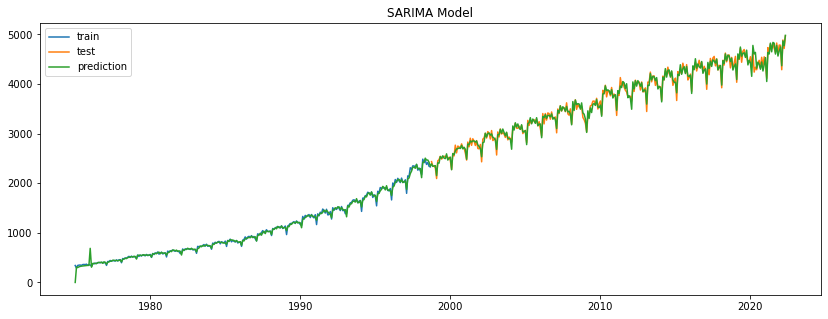

In [10]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='train')
ax.plot(test_data, label='test')
# ax.plot(df['Electricity Generation'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [6]:
mae = mean_absolute_error(df['Electricity Generation'], pred)
mape = mean_absolute_percentage_error(df['Electricity Generation'], pred)
mse = mean_squared_error(df['Electricity Generation'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,37.923321,0.021623,3230.746274,56.839654


In [7]:
## split into train and test data
train_data = df[df.index<='1998-09']
test_data = df[df.index>'1998-09']

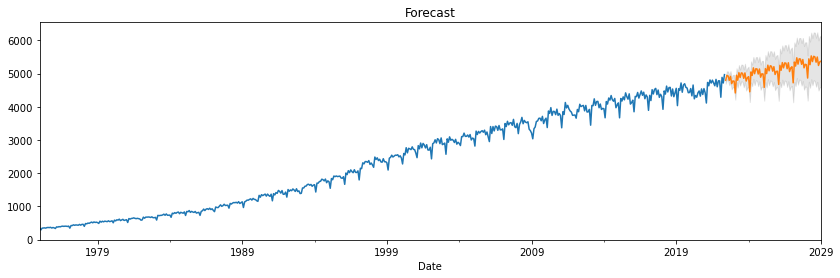

In [8]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=80)

## confidence intervals
fore_ci = forecast.conf_int()
ax = df['Electricity Generation'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("Forecast")
plt.show()

https://tablebuilder.singstat.gov.sg/table/TS/M890831
https://www.ema.gov.sg/ourenergystory